### Packages & global parameters

We will need to import the \`torch\` package for the main functionality.
In addition to the previous sheet, In order to have a convenient, we will use PyTorch&rsquo;s \`DataLoader\` and \`Dataset\` in order to feed our training data to the model.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
import numpy as np
import kagglehub
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset from Kaggle
Source:

The dataset was created by Angeliki Xifara (angxifara '@' gmail.com, Civil/Structural Engineer) and was processed by Athanasios Tsanas (tsanasthanasis '@' gmail.com, Oxford Centre for Industrial and Applied Mathematics, University of Oxford, UK).

Data Set Information:

We perform energy analysis using 12 different building shapes simulated in Ecotect. The buildings differ with respect to the glazing area, the glazing area distribution, and the orientation, amongst other parameters. We simulate various settings as functions of the afore-mentioned characteristics to obtain 768 building shapes. The dataset comprises 768 samples and 8 features, aiming to predict two real valued responses. It can also be used as a multi-class classification problem if the response is rounded to the nearest integer.

In [ ]:


# Download latest version
path = kagglehub.dataset_download("elikplim/eergy-efficiency-dataset")

print("Path to dataset files:", path)

100%|██████████| 6.22k/6.22k [00:00<00:00, 9.67MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/elikplim/eergy-efficiency-dataset/versions/1


### Change Dataset into Data Frame


In [ ]:


df = pd.read_csv('/kaggle/input/eergy-efficiency-dataset/ENB2012_data.csv')

In [ ]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


###Table Properties on this dataset
Specifically:\
X1-Relative Compactness\
X2-Surface Area\
X3-Wall Area\
X4-Roof Area\
X5-Overall Height\
X6-Orientation\
X7-Glazing Area\
X8-Glazing Area Distribution\
y1-Heating Load\
y2-Cooling Load\

In [ ]:
df.rename(columns={'X1':'Relative Compactness','X2':'Surface Area','X3':'Wall Area','X4':'Roof Area',
                   'X5': 'Overall Height', 'X6':'Orientation', 'X7':'Glazing Area', 'X8':'Glazing Area Dist',
                   'Y1':'Heating Load','Y2':'Cooling Load'}, inplace= True)

In [ ]:
df.head()

,Relative Compactness,Surface Area,Wall Area,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Dist,Heating Load,Cooling Load
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


There is no null or missing data on each columns so we good at this moment. we don't need to change anything except changing the column name.

In [ ]:
df.isna().sum()

,0
Relative Compactness,0
Surface Area,0
Wall Area,0
Roof Area,0
Overall Height,0
Orientation,0
Glazing Area,0
Glazing Area Dist,0
Heating Load,0
Cooling Load,0


### EDA and Data Visalization

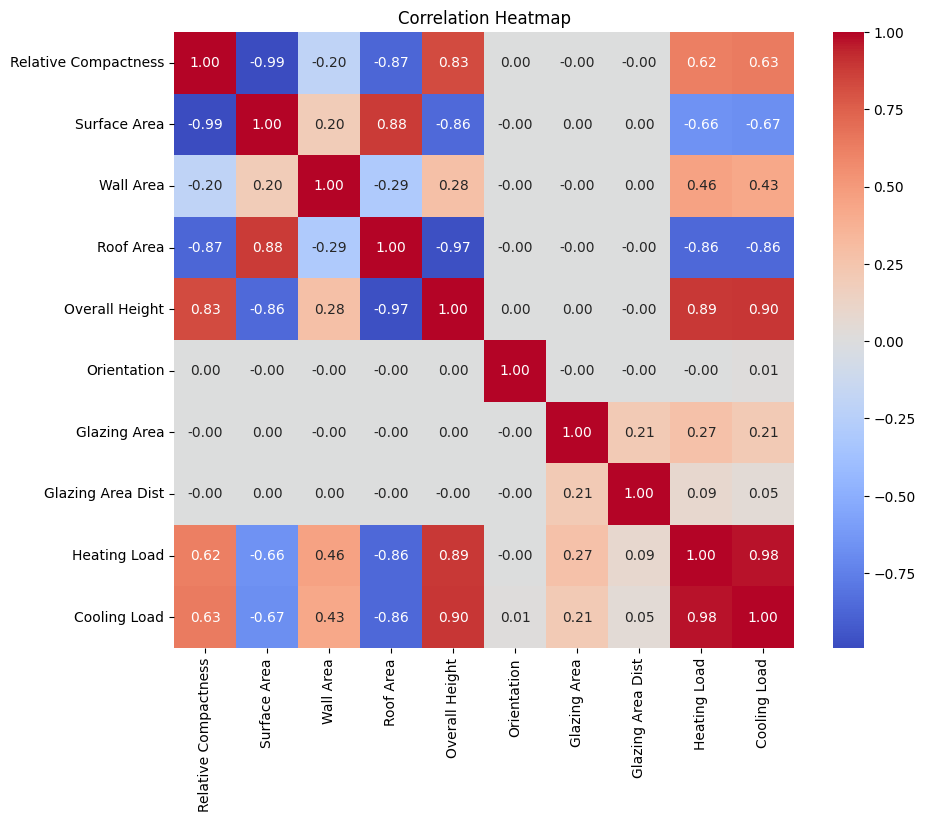

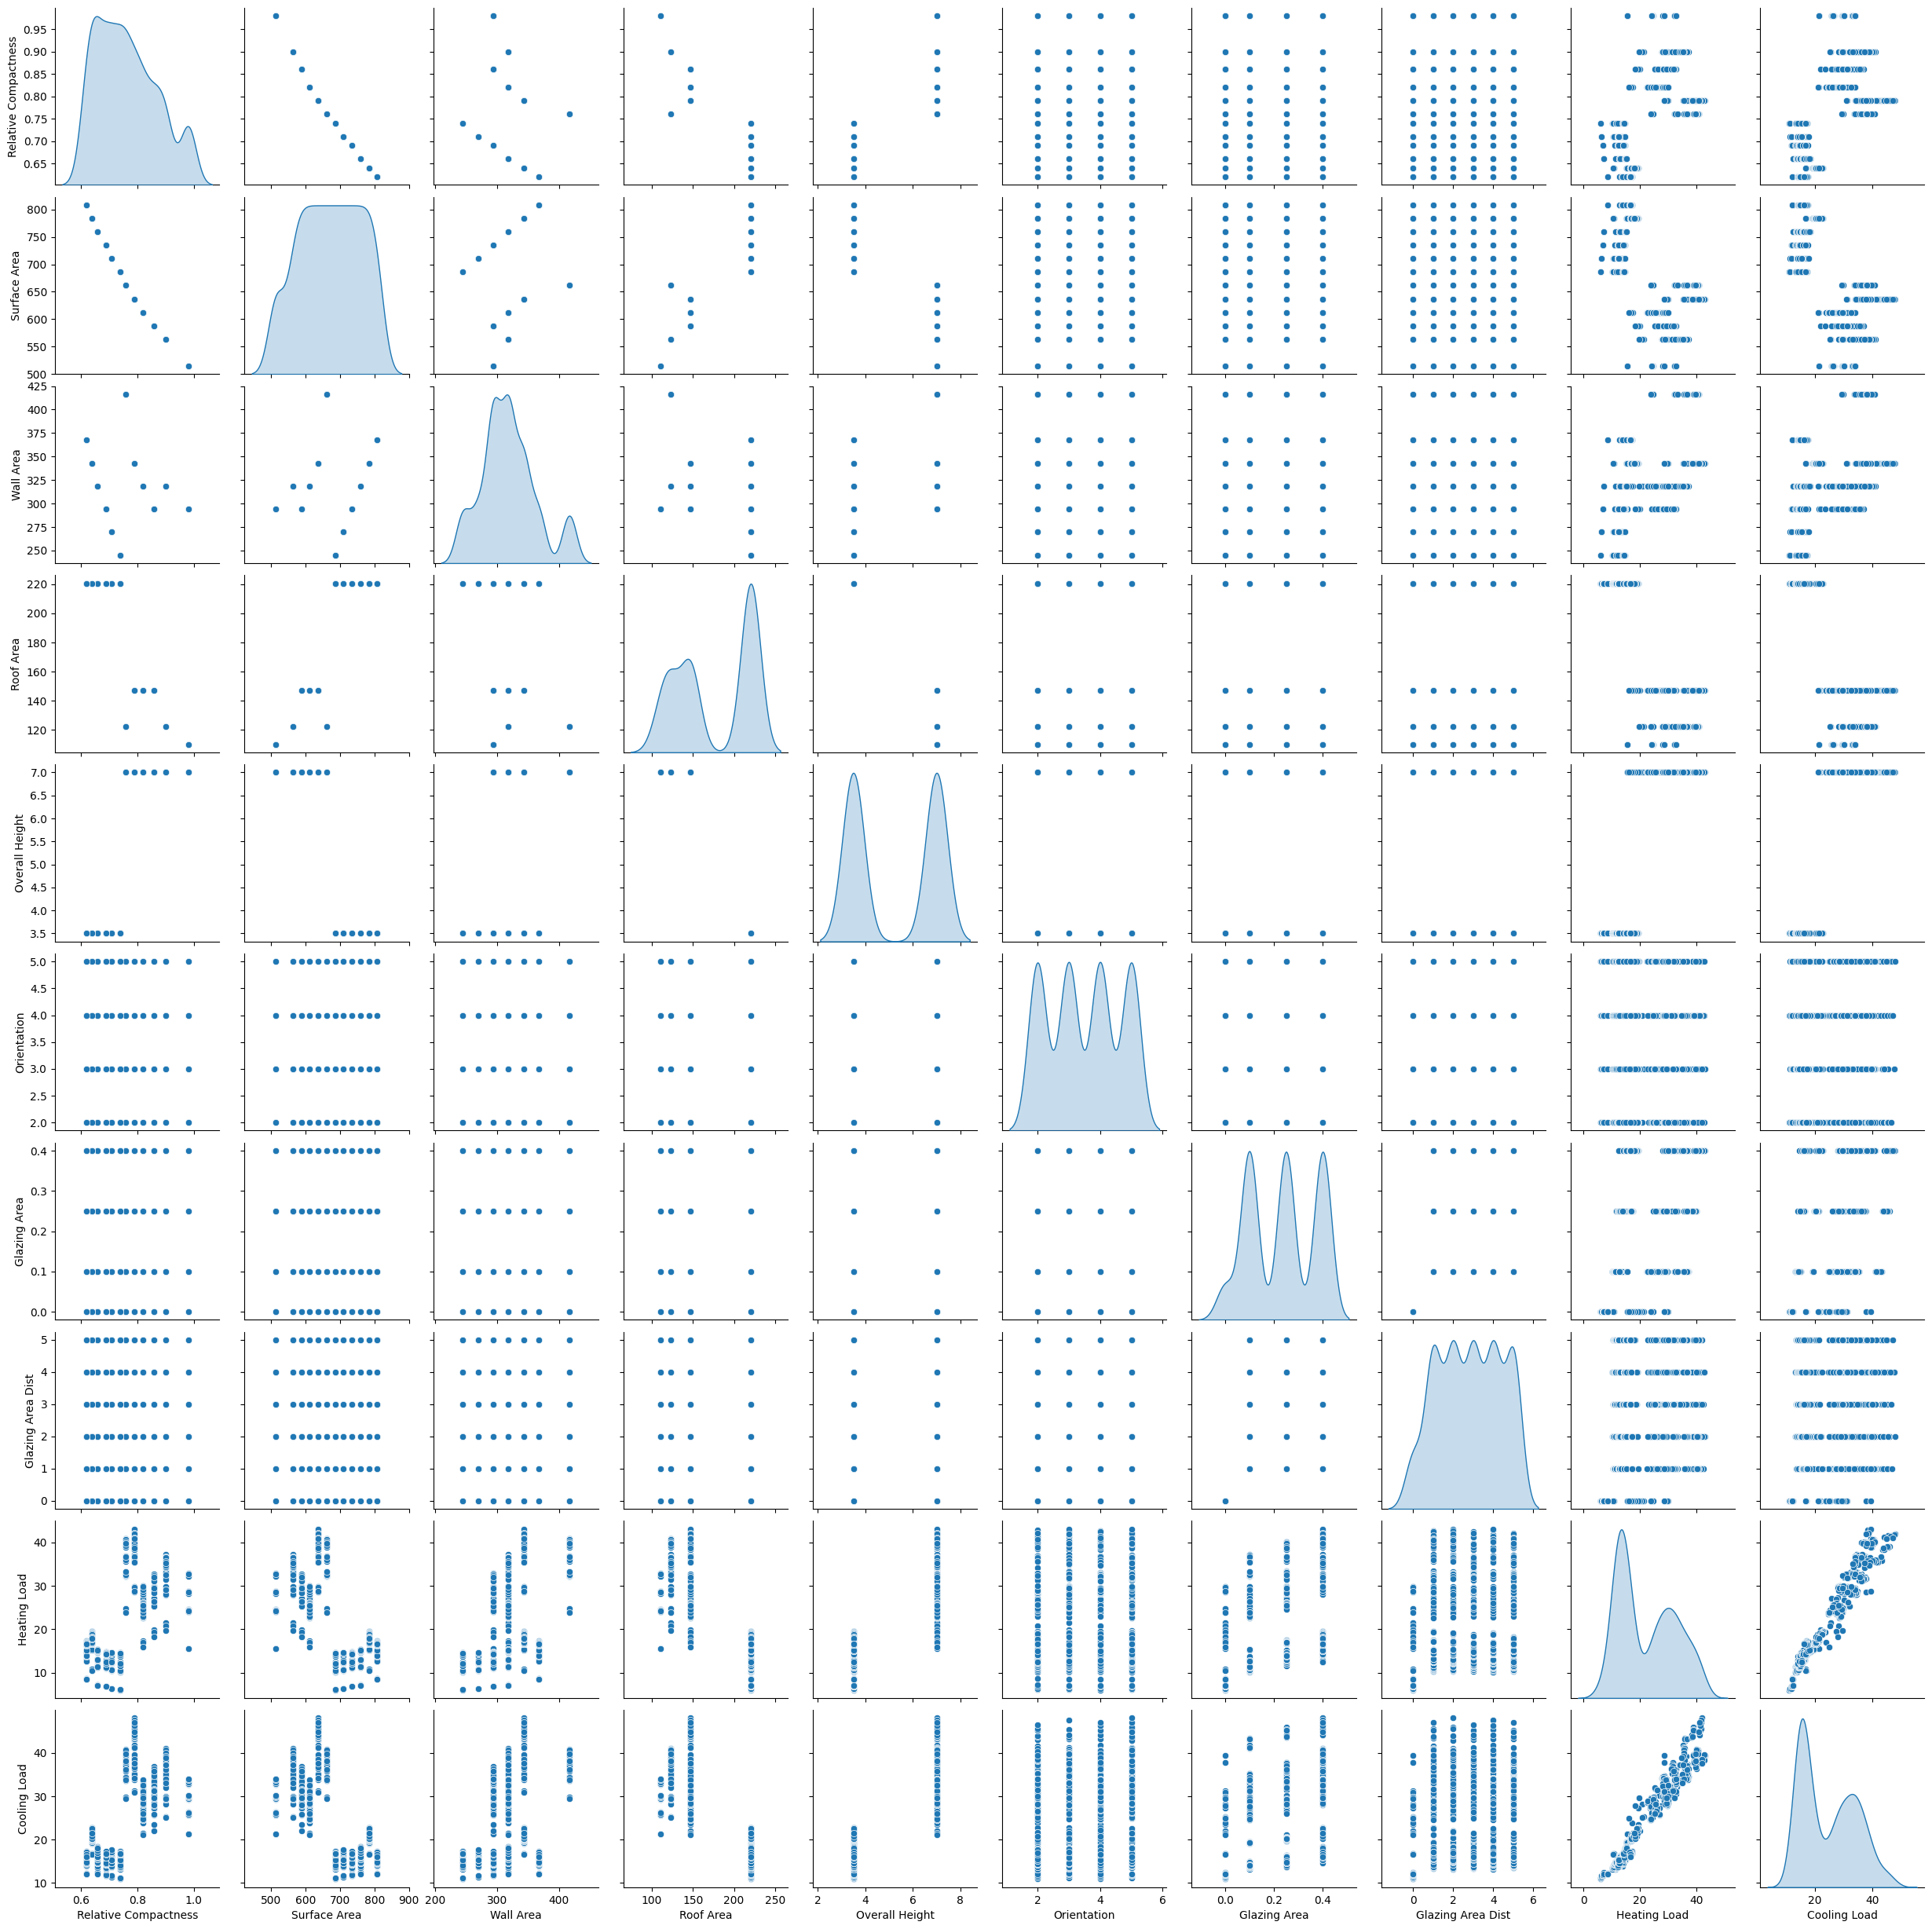

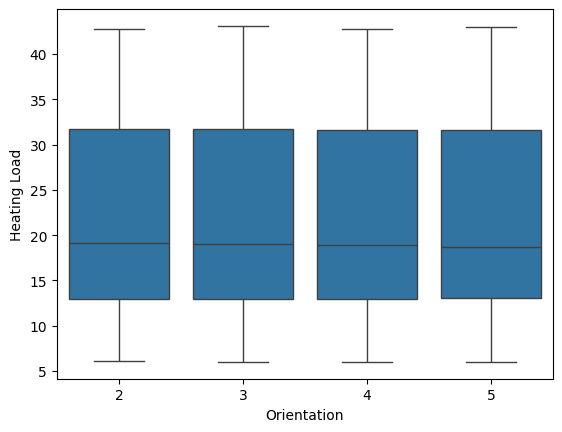

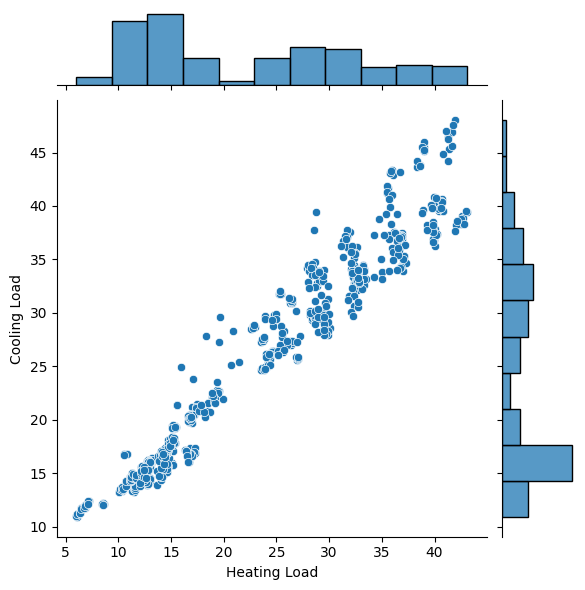

In [ ]:
#EDA

# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt =".2f")
plt.title("Correlation Heatmap")
plt.show()

# Pairplot
sns.pairplot(df, diag_kind="kde")
plt.show()

# Boxplot by orientation
sns.boxplot(x="Orientation", y="Heating Load", data=df)
plt.show()

# Jointplot
sns.jointplot(x="Heating Load", y="Cooling Load", data=df, kind="scatter")
plt.show()


In [ ]:
clean_df = df.drop(columns=['Glazing Area','Glazing Area Dist','Orientation'])

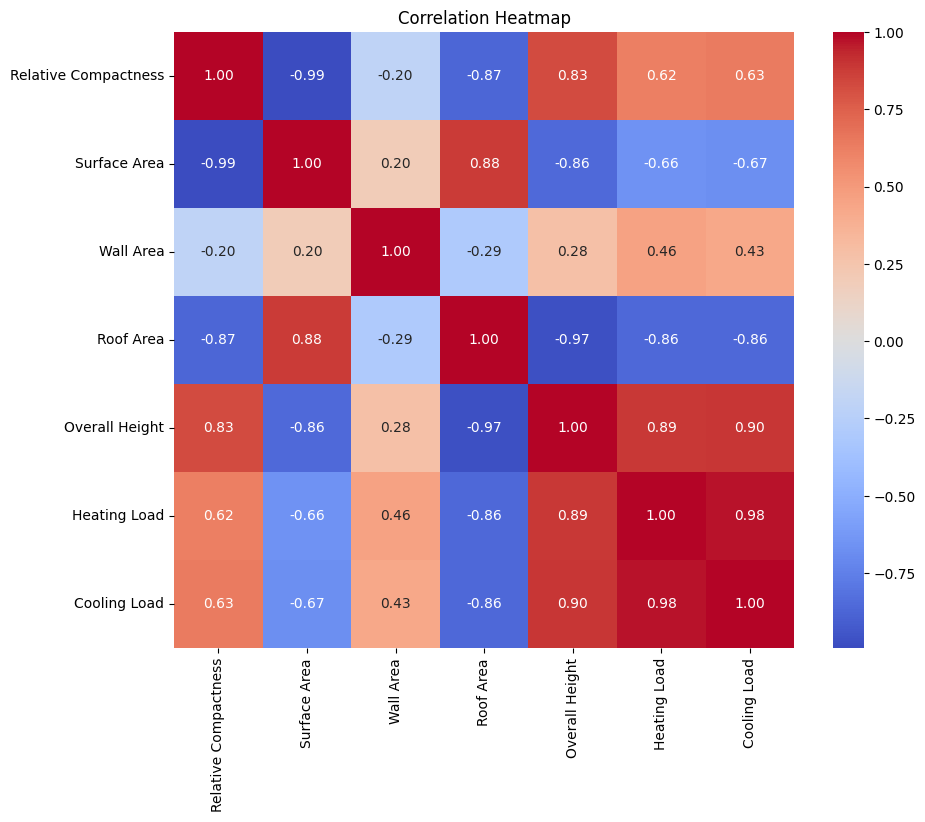

In [ ]:
# Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(clean_df.corr(), annot=True, cmap="coolwarm", fmt =".2f")
plt.title("Correlation Heatmap")
plt.show()


/tmp/ipython-input-1600437253.py:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Orientation", y="Heating Load", data=df, estimator="mean", ci=None, palette="coolwarm")
/tmp/ipython-input-1600437253.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Orientation", y="Heating Load", data=df, estimator="mean", ci=None, palette="coolwarm")
/tmp/ipython-input-1600437253.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="Orientation", y="Cooling Load", data=df, estimator="mean", ci=None, palette="viridis")
/tmp/ipython-input-1600437253.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same

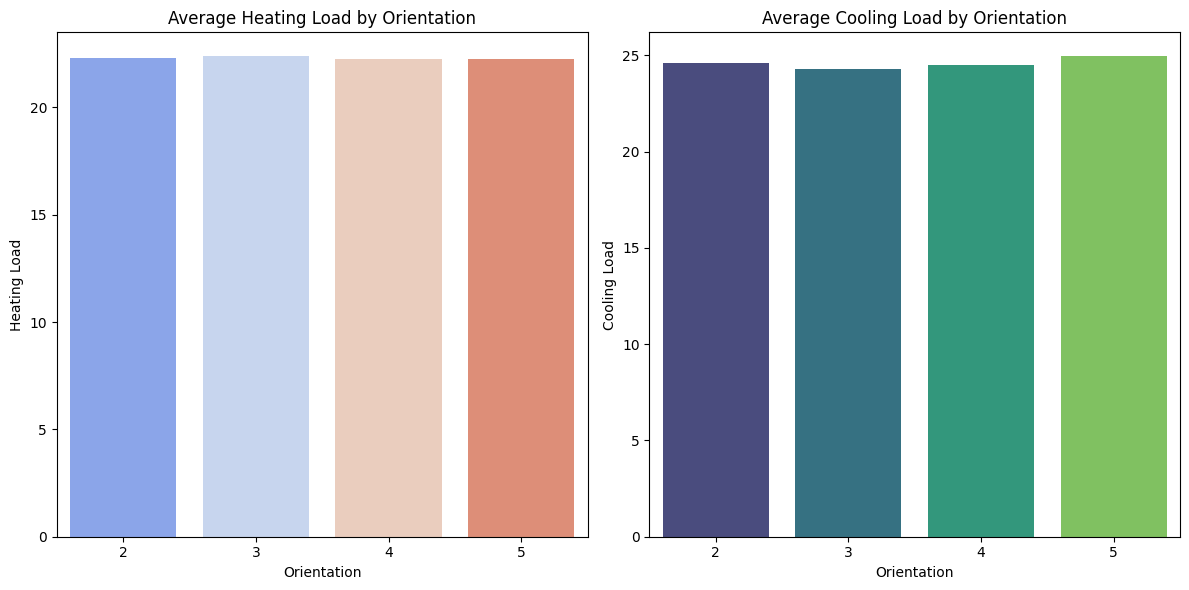

In [ ]:
plt.figure(figsize=(12,6)) # Heating Load by Orientation
plt.subplot(1,2,1)
sns.barplot(x="Orientation", y="Heating Load", data=df, estimator="mean", ci=None, palette="coolwarm")
plt.title("Average Heating Load by Orientation")
# Cooling Load by Orientation
plt.subplot(1,2,2)
sns.barplot(x="Orientation", y="Cooling Load", data=df, estimator="mean", ci=None, palette="viridis")
plt.title("Average Cooling Load by Orientation")
plt.tight_layout()
plt.show()

### Deep Leaerning
In this experiment we will use 6 model with MLP (Multi Layer Percepteron) Regressor with different neurons and activation function (ReLU, ELU, LeakyReLU).

In [ ]:
#Deep Learning
X = df.drop(columns=['Glazing Area Dist','Orientation','Heating Load', 'Cooling Load'])
y = df[['Heating Load', 'Cooling Load']]

print("Features (X) head:")
print(X.head())
print("\nTargets (y) head:")
print(y.head())

Features (X) head:
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   Glazing Area  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  

Targets (y) head:
   Heating Load  Cooling Load
0         15.55         21.33
1         15.55         21.33
2         15.55         21.33
3         15.55         21.33
4         20.84         28.28


In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Relative Compactness  768 non-null    float64
 1   Surface Area          768 non-null    float64
 2   Wall Area             768 non-null    float64
 3   Roof Area             768 non-null    float64
 4   Overall Height        768 non-null    float64
 5   Glazing Area          768 non-null    float64
dtypes: float64(6)
memory usage: 36.1 KB


In [ ]:
y.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Heating Load  768 non-null    float64
 1   Cooling Load  768 non-null    float64
dtypes: float64(2)
memory usage: 12.1 KB


### Creating Model

In [ ]:
class MultiOutputMLP(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MultiOutputMLP, self).__init__()
    self.fc1 = nn.Linear(input_dim, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, output_dim)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x


In [ ]:
class MultiOutputMLP2(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MultiOutputMLP2, self).__init__()
    self.fc1 = nn.Linear(input_dim, 300)
    self.fc2 = nn.Linear(300, 150)
    self.fc3 = nn.Linear(150, output_dim)

    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
class MultiOutputMLP_LeakyReLU(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MultiOutputMLP_LeakyReLU, self).__init__()
    self.fc1 = nn.Linear(input_dim, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, output_dim)

    self.relu = nn.LeakyReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
class MultiOutputMLP_LeakyReLU2(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MultiOutputMLP_LeakyReLU2, self).__init__()
    self.fc1 = nn.Linear(input_dim, 300)
    self.fc2 = nn.Linear(300, 150)
    self.fc3 = nn.Linear(150, output_dim)

    self.relu = nn.LeakyReLU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
class MultiOutputMLP_ELU(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MultiOutputMLP_ELU, self).__init__()
    self.fc1 = nn.Linear(input_dim, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, output_dim)

    self.relu = nn.ELU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
class MultiOutputMLP_ELU2(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(MultiOutputMLP_ELU2, self).__init__()
    self.fc1 = nn.Linear(input_dim, 300)
    self.fc2 = nn.Linear(300, 150)
    self.fc3 = nn.Linear(150, output_dim)

    self.relu = nn.ELU()

  def forward(self, x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [ ]:
class EnergyDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y
  def __len__(self): return len(self.X)
  def __getitem__(self, idx): return self.X[idx], self.y[idx]

In [ ]:
model = MultiOutputMLP(6,2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
model2 = MultiOutputMLP2(6,2)
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)

In [ ]:
model3 = MultiOutputMLP_LeakyReLU(6,2)
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model3.parameters(), lr=0.001)

In [ ]:
model4 = MultiOutputMLP_LeakyReLU2(6,2)
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model4.parameters(), lr=0.001)

In [ ]:
model5 = MultiOutputMLP_ELU(6,2)
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model5.parameters(), lr=0.001)

In [ ]:
model6 = MultiOutputMLP_ELU2(6,2)
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model6.parameters(), lr=0.001)

### Training and Testing Model

In [ ]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

In [ ]:
train_dataset = EnergyDataset(X_train, y_train)
test_dataset = EnergyDataset(X_test, y_test)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
for epoch in range(50):
  model.train()
  train_loss = 0
  for inputs, targets in train_loader:
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)
  print(f"Epoch {epoch+1}/{50}, Train Loss: {avg_train_loss:.4f}")

Epoch 1/50, Train Loss: 334.0111
Epoch 2/50, Train Loss: 338.5009
Epoch 3/50, Train Loss: 333.8348
Epoch 4/50, Train Loss: 335.3613
Epoch 5/50, Train Loss: 333.7230
Epoch 6/50, Train Loss: 342.2848
Epoch 7/50, Train Loss: 334.7386
Epoch 8/50, Train Loss: 335.7662
Epoch 9/50, Train Loss: 333.6772
Epoch 10/50, Train Loss: 332.2621
Epoch 11/50, Train Loss: 336.7808
Epoch 12/50, Train Loss: 336.2147
Epoch 13/50, Train Loss: 335.7196
Epoch 14/50, Train Loss: 336.1362
Epoch 15/50, Train Loss: 334.7203
Epoch 16/50, Train Loss: 337.2803
Epoch 17/50, Train Loss: 336.4941
Epoch 18/50, Train Loss: 333.0176
Epoch 19/50, Train Loss: 335.5532
Epoch 20/50, Train Loss: 339.2551
Epoch 21/50, Train Loss: 338.8333
Epoch 22/50, Train Loss: 337.6599
Epoch 23/50, Train Loss: 333.0419
Epoch 24/50, Train Loss: 332.4043
Epoch 25/50, Train Loss: 336.8821
Epoch 26/50, Train Loss: 337.1327
Epoch 27/50, Train Loss: 334.5405
Epoch 28/50, Train Loss: 337.7066
Epoch 29/50, Train Loss: 334.2930
Epoch 30/50, Train Loss

In [ ]:
for epoch in range(50):
  model2.train()
  train_loss = 0
  for inputs, targets in train_loader:
    outputs = model2(inputs)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)
  print(f"Epoch {epoch+1}/{50}, Train Loss: {avg_train_loss:.4f}")

Epoch 1/50, Train Loss: 13.0460
Epoch 2/50, Train Loss: 14.3865
Epoch 3/50, Train Loss: 14.2685
Epoch 4/50, Train Loss: 14.6420
Epoch 5/50, Train Loss: 13.0286
Epoch 6/50, Train Loss: 13.5215
Epoch 7/50, Train Loss: 17.3555
Epoch 8/50, Train Loss: 19.5135
Epoch 9/50, Train Loss: 16.3532
Epoch 10/50, Train Loss: 13.4787
Epoch 11/50, Train Loss: 13.3984
Epoch 12/50, Train Loss: 14.3145
Epoch 13/50, Train Loss: 14.0836
Epoch 14/50, Train Loss: 13.0273
Epoch 15/50, Train Loss: 12.9266
Epoch 16/50, Train Loss: 13.4751
Epoch 17/50, Train Loss: 14.2127
Epoch 18/50, Train Loss: 13.8357
Epoch 19/50, Train Loss: 12.7247
Epoch 20/50, Train Loss: 14.9678
Epoch 21/50, Train Loss: 13.8947
Epoch 22/50, Train Loss: 13.6620
Epoch 23/50, Train Loss: 15.0290
Epoch 24/50, Train Loss: 16.8427
Epoch 25/50, Train Loss: 13.5163
Epoch 26/50, Train Loss: 13.7986
Epoch 27/50, Train Loss: 13.7125
Epoch 28/50, Train Loss: 15.0503
Epoch 29/50, Train Loss: 13.5825
Epoch 30/50, Train Loss: 13.5680
Epoch 31/50, Train 

In [ ]:
for epoch in range(50):
  model3.train()
  train_loss = 0
  for inputs, targets in train_loader:
    outputs = model3(inputs)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)
  print(f"Epoch {epoch+1}/{50}, Train Loss: {avg_train_loss:.4f}")

Epoch 1/50, Train Loss: 145.2322
Epoch 2/50, Train Loss: 146.8211
Epoch 3/50, Train Loss: 144.0023
Epoch 4/50, Train Loss: 150.6762
Epoch 5/50, Train Loss: 147.3646
Epoch 6/50, Train Loss: 148.1282
Epoch 7/50, Train Loss: 144.4567
Epoch 8/50, Train Loss: 146.3552
Epoch 9/50, Train Loss: 144.4164
Epoch 10/50, Train Loss: 147.5962
Epoch 11/50, Train Loss: 144.9802
Epoch 12/50, Train Loss: 147.1801
Epoch 13/50, Train Loss: 146.8312
Epoch 14/50, Train Loss: 148.3746
Epoch 15/50, Train Loss: 148.3251
Epoch 16/50, Train Loss: 148.2658
Epoch 17/50, Train Loss: 146.2220
Epoch 18/50, Train Loss: 146.0842
Epoch 19/50, Train Loss: 144.9558
Epoch 20/50, Train Loss: 146.4169
Epoch 21/50, Train Loss: 147.0785
Epoch 22/50, Train Loss: 146.9829
Epoch 23/50, Train Loss: 146.9931
Epoch 24/50, Train Loss: 146.3468
Epoch 25/50, Train Loss: 144.1829
Epoch 26/50, Train Loss: 145.8125
Epoch 27/50, Train Loss: 145.7721
Epoch 28/50, Train Loss: 145.6565
Epoch 29/50, Train Loss: 145.4753
Epoch 30/50, Train Loss

In [ ]:
for epoch in range(50):
  model4.train()
  train_loss = 0
  for inputs, targets in train_loader:
    outputs = model4(inputs)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)
  print(f"Epoch {epoch+1}/{50}, Train Loss: {avg_train_loss:.4f}")

Epoch 1/50, Train Loss: 835.0842
Epoch 2/50, Train Loss: 835.8212
Epoch 3/50, Train Loss: 823.8510
Epoch 4/50, Train Loss: 834.9180
Epoch 5/50, Train Loss: 845.6763
Epoch 6/50, Train Loss: 840.4835
Epoch 7/50, Train Loss: 834.5323
Epoch 8/50, Train Loss: 831.5344
Epoch 9/50, Train Loss: 829.6440
Epoch 10/50, Train Loss: 838.1654
Epoch 11/50, Train Loss: 852.0869
Epoch 12/50, Train Loss: 845.1213
Epoch 13/50, Train Loss: 842.8733
Epoch 14/50, Train Loss: 835.4965
Epoch 15/50, Train Loss: 844.9764
Epoch 16/50, Train Loss: 846.2992
Epoch 17/50, Train Loss: 838.3302
Epoch 18/50, Train Loss: 851.7131
Epoch 19/50, Train Loss: 844.8967
Epoch 20/50, Train Loss: 847.8338
Epoch 21/50, Train Loss: 835.9158
Epoch 22/50, Train Loss: 822.7299
Epoch 23/50, Train Loss: 853.9407
Epoch 24/50, Train Loss: 833.2581
Epoch 25/50, Train Loss: 833.3488
Epoch 26/50, Train Loss: 827.0366
Epoch 27/50, Train Loss: 841.2810
Epoch 28/50, Train Loss: 838.1315
Epoch 29/50, Train Loss: 827.2087
Epoch 30/50, Train Loss

In [ ]:
for epoch in range(50):
  model5.train()
  train_loss = 0
  for inputs, targets in train_loader:
    outputs = model5(inputs)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)
  print(f"Epoch {epoch+1}/{50}, Train Loss: {avg_train_loss:.4f}")

Epoch 1/50, Train Loss: 1759.4918
Epoch 2/50, Train Loss: 1741.0787
Epoch 3/50, Train Loss: 1740.1792
Epoch 4/50, Train Loss: 1754.3155
Epoch 5/50, Train Loss: 1756.1886
Epoch 6/50, Train Loss: 1742.0372
Epoch 7/50, Train Loss: 1744.0363
Epoch 8/50, Train Loss: 1751.8026
Epoch 9/50, Train Loss: 1759.1996
Epoch 10/50, Train Loss: 1758.2068
Epoch 11/50, Train Loss: 1768.3420
Epoch 12/50, Train Loss: 1740.3726
Epoch 13/50, Train Loss: 1749.2117
Epoch 14/50, Train Loss: 1753.1386
Epoch 15/50, Train Loss: 1748.0589
Epoch 16/50, Train Loss: 1752.9705
Epoch 17/50, Train Loss: 1766.0486
Epoch 18/50, Train Loss: 1750.6591
Epoch 19/50, Train Loss: 1760.1865
Epoch 20/50, Train Loss: 1763.6699
Epoch 21/50, Train Loss: 1748.8937
Epoch 22/50, Train Loss: 1758.4481
Epoch 23/50, Train Loss: 1747.2384
Epoch 24/50, Train Loss: 1745.7219
Epoch 25/50, Train Loss: 1746.3157
Epoch 26/50, Train Loss: 1732.7828
Epoch 27/50, Train Loss: 1750.3448
Epoch 28/50, Train Loss: 1748.3938
Epoch 29/50, Train Loss: 1752

In [ ]:
for epoch in range(50):
  model6.train()
  train_loss = 0
  for inputs, targets in train_loader:
    outputs = model6(inputs)
    loss = criterion(outputs, targets)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)
  print(f"Epoch {epoch+1}/{50}, Train Loss: {avg_train_loss:.4f}")

Epoch 1/50, Train Loss: 411.3954
Epoch 2/50, Train Loss: 405.3998
Epoch 3/50, Train Loss: 407.8621
Epoch 4/50, Train Loss: 410.6787
Epoch 5/50, Train Loss: 414.9049
Epoch 6/50, Train Loss: 411.3638
Epoch 7/50, Train Loss: 420.1200
Epoch 8/50, Train Loss: 402.3271
Epoch 9/50, Train Loss: 407.9923
Epoch 10/50, Train Loss: 404.9418
Epoch 11/50, Train Loss: 421.0136
Epoch 12/50, Train Loss: 412.5103
Epoch 13/50, Train Loss: 409.2470
Epoch 14/50, Train Loss: 412.0405
Epoch 15/50, Train Loss: 418.5839
Epoch 16/50, Train Loss: 404.9861
Epoch 17/50, Train Loss: 414.9691
Epoch 18/50, Train Loss: 405.7905
Epoch 19/50, Train Loss: 401.2798
Epoch 20/50, Train Loss: 407.6904
Epoch 21/50, Train Loss: 410.5036
Epoch 22/50, Train Loss: 407.3311
Epoch 23/50, Train Loss: 411.9729
Epoch 24/50, Train Loss: 420.2119
Epoch 25/50, Train Loss: 410.9050
Epoch 26/50, Train Loss: 417.6254
Epoch 27/50, Train Loss: 410.7281
Epoch 28/50, Train Loss: 411.8405
Epoch 29/50, Train Loss: 408.1335
Epoch 30/50, Train Loss

### Model Evaluation

In [ ]:
model.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
  for inputs, targets in test_loader:
    outputs = model(inputs)
    y_pred_list.append(outputs.numpy())
    y_true_list.append(targets.numpy())


y_pred = np.vstack(y_pred_list)
y_true = np.vstack(y_true_list)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

MSE: 337.9689
MAE: 15.0631
R2 Score: -2.4090


In [ ]:
model2.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
  for inputs, targets in test_loader:
    outputs = model2(inputs)
    y_pred_list.append(outputs.numpy())
    y_true_list.append(targets.numpy())


y_pred = np.vstack(y_pred_list)
y_true = np.vstack(y_true_list)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

MSE: 12.2571
MAE: 2.7036
R2 Score: 0.8754


In [ ]:
model3.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
  for inputs, targets in test_loader:
    outputs = model3(inputs)
    y_pred_list.append(outputs.numpy())
    y_true_list.append(targets.numpy())


y_pred = np.vstack(y_pred_list)
y_true = np.vstack(y_true_list)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

MSE: 152.4836
MAE: 11.4402
R2 Score: -0.5540


In [ ]:
model4.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
  for inputs, targets in test_loader:
    outputs = model4(inputs)
    y_pred_list.append(outputs.numpy())
    y_true_list.append(targets.numpy())


y_pred = np.vstack(y_pred_list)
y_true = np.vstack(y_true_list)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

MSE: 886.5511
MAE: 27.2662
R2 Score: -7.8527


In [ ]:
model5.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
  for inputs, targets in test_loader:
    outputs = model5(inputs)
    y_pred_list.append(outputs.numpy())
    y_true_list.append(targets.numpy())


y_pred = np.vstack(y_pred_list)
y_true = np.vstack(y_true_list)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

MSE: 1767.0762
MAE: 34.0805
R2 Score: -16.0296


In [ ]:
model6.eval()
y_pred_list = []
y_true_list = []

with torch.no_grad():
  for inputs, targets in test_loader:
    outputs = model6(inputs)
    y_pred_list.append(outputs.numpy())
    y_true_list.append(targets.numpy())


y_pred = np.vstack(y_pred_list)
y_true = np.vstack(y_true_list)

mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R2 Score: {r2:.4f}")

MSE: 438.6932
MAE: 18.0300
R2 Score: -3.3414


/tmp/ipython-input-3712608371.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=heating_corr.values, y=heating_corr.index, palette='viridis')
/tmp/ipython-input-3712608371.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cooling_corr.values, y=cooling_corr.index, palette='magma')


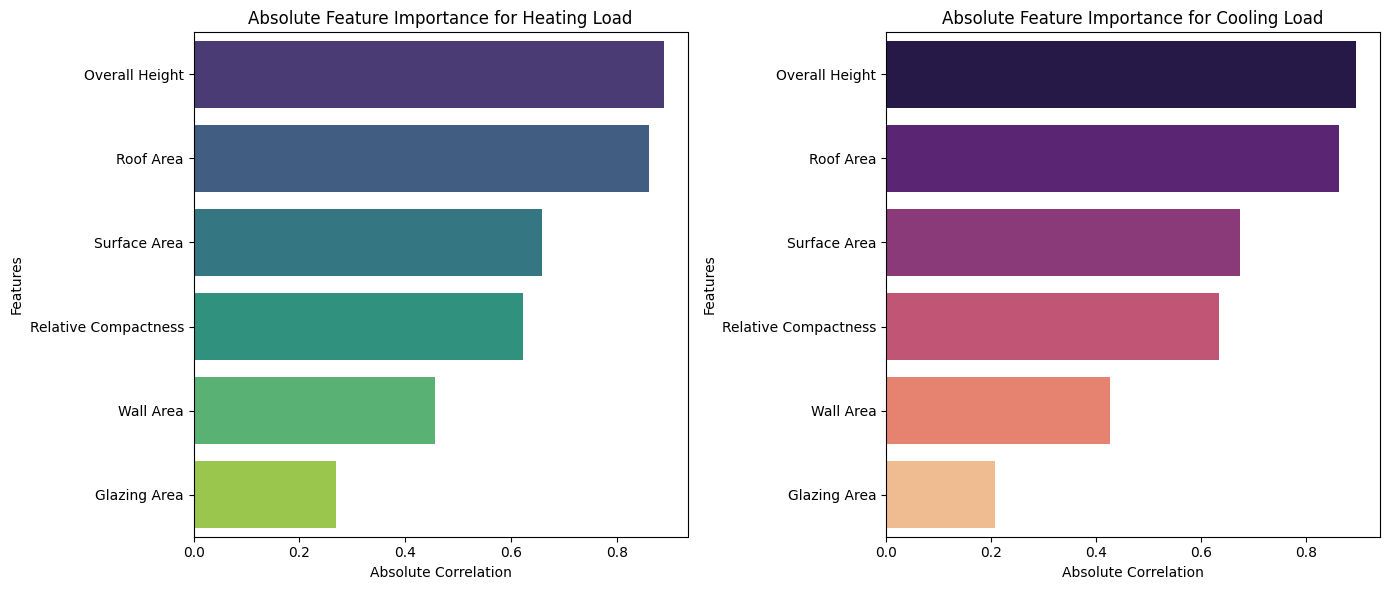

In [ ]:
# Combine X and y for correlation calculation
df_combined = pd.concat([X, y], axis=1)

# Calculate correlations with 'Heating Load'
heating_corr = df_combined.corr()['Heating Load'].drop(['Heating Load', 'Cooling Load']).abs().sort_values(ascending=False)

# Calculate correlations with 'Cooling Load'
cooling_corr = df_combined.corr()['Cooling Load'].drop(['Heating Load', 'Cooling Load']).abs().sort_values(ascending=False)

plt.figure(figsize=(14, 6))

# Plot Feature Importance for Heating Load
plt.subplot(1, 2, 1)
sns.barplot(x=heating_corr.values, y=heating_corr.index, palette='viridis')
plt.title('Absolute Feature Importance for Heating Load')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')

# Plot Feature Importance for Cooling Load
plt.subplot(1, 2, 2)
sns.barplot(x=cooling_corr.values, y=cooling_corr.index, palette='magma')
plt.title('Absolute Feature Importance for Cooling Load')
plt.xlabel('Absolute Correlation')
plt.ylabel('Features')

plt.tight_layout()
plt.show()